In this notebook, using VGG16 with Batch Normalization and adding own fully-connected layers.  Also, in lieu of pre-processed image data loaded into single tensors (one for train, validation and test, respectively), will revert back to the flow_from_directory method from Keras (applying to pre-cropped images as per the annotation data provided by the Stanford dataset). 

In [1]:
import numpy as np
from keras.models import Sequential
from utils_channels_last import Vgg16BN
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from keras import backend as K

c:\users\Abhi\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os

from tensorflow.python.client import device_lib
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
print(device_lib.list_local_devices())

# configure tensorflow before fitting model
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.Session(config=tf_config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14683855823917919877
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1493781708
locality {
  bus_id: 1
}
incarnation: 9270316920790285344
physical_device_desc: "device: 0, name: GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
# changing directory for flow_from_directory method
os.chdir('C:\\Users\\Abhi\\Documents\\Capstone\\datasets')

## Classifying the Dog Breed Using (Transfer Leraning)
Here we are using  pretrained VGG16BN network, which is a VGG16 architecture with Batch Normalization.  This addition of Batch Normalization is useful in my case as we have such few samples per class and aids in overfitting.  However, this doesn't meant that overfitting is avoidable. 

In [4]:
batch_size=12
num_classes = 120
image_size = 224
num_channels = 3

## IMAGE DATA  AUGMENTATION 
Here we use data Augmentation as Described in the previous post.

In [5]:
train_datagen = ImageDataGenerator(rotation_range=15, shear_range=0.1, channel_shift_range=20,
                                    width_shift_range=0.1,  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True,
                                  validation_split=0.2)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('cropped/train', target_size=(224,224),
            class_mode='categorical', shuffle=True, batch_size=batch_size, subset='training')

validation_generator = train_datagen.flow_from_directory('cropped/train', target_size=(224,224),
            class_mode='categorical', shuffle=True, batch_size=batch_size, subset='validation')

test_generator = test_datagen.flow_from_directory('cropped/test', target_size=(224,224),
            class_mode='categorical', shuffle=False, batch_size=batch_size)

Found 9600 images belonging to 120 classes.
Found 2400 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [10]:
base_model = Vgg16BN(include_top=False).model
x = base_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
# let's add two fully-connected layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
# and a final FC layer with 'softmax' activation since we are doing a multi-class problem 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

C:\Users\Abhi\Documents\GitHub\DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET\utils_channels_last.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\Abhi\Documents\GitHub\DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET\utils_channels_last.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\Abhi\Documents\GitHub\DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET\utils_channels_last.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\Abhi\Documents\GitHub\DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET\utils_channels_last.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1_input (InputLayer)  (None, 3, 224, 224)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
__________

c:\users\Abhi\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("la..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [44]:
from keras.callbacks import ModelCheckpoint

In [17]:
model.load_weights('saved_models/weights.vgg16_BN_finetuned.h5')

In [13]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.pre_trained_vgg16_v3.hdf5', 
                               verbose=1, save_best_only=True)


history = model.fit_generator(train_generator, steps_per_epoch=800, epochs=25, 
                              validation_data=validation_generator,
                              callbacks=[checkpointer])

Epoch 1/25
800/800 [==============================] - 444s 555ms/step - loss: 4.4294 - acc: 0.0727 - val_loss: 3.4439 - val_acc: 0.1908

Epoch 00001: val_loss improved from inf to 3.44385, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16_v3.hdf5
Epoch 2/25
800/800 [==============================] - 401s 501ms/step - loss: 3.5030 - acc: 0.1753 - val_loss: 2.8733 - val_acc: 0.3125

Epoch 00002: val_loss improved from 3.44385 to 2.87333, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16_v3.hdf5
Epoch 3/25
800/800 [==============================] - 401s 502ms/step - loss: 3.0068 - acc: 0.2560 - val_loss: 2.5689 - val_acc: 0.3767

Epoch 00003: val_loss improved from 2.87333 to 2.56890, saving model to saved_models/weights.bestaugmented.pre_trained_vgg16_v3.hdf5
Epoch 4/25
800/800 [==============================] - 402s 502ms/step - loss: 2.6733 - acc: 0.3266 - val_loss: 2.3388 - val_acc: 0.4217

Epoch 00004: val_loss improved from 2.56890 to 2.33881, s

In [14]:
# saving what we have so far
model.save('saved_models/vgg16_BN_finetuned.h5')
model.save_weights('saved_models/weights.vgg16_BN_finetuned.h5')

In [25]:
# not sure if I need this later but saving the classes from the generator object and the respective indices
label_dict = train_generator.class_indices

In [93]:
# lets plot/visualize the model training progress

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

font = {'family' : 'sans-serif',
        'weight' : 'medium',
        'size'   : 16}

plt.rc('font', **font)

In [21]:
def plot_history(history, figsize=(8,8)):
    '''
    Args: the history attribute of model.fit, figure size (defaults to (8,8))
    Description: Takes the history object and plots the loss and accuracy metrics (both train and validation)
    Returns: Plots of Loss and Accuracy from model training
    '''
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1, figsize=figsize)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    
    ## Accuracy
    plt.figure(2, figsize=figsize)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    plt.show()

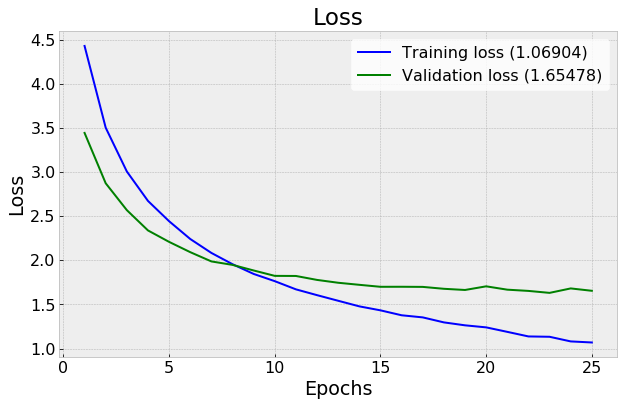

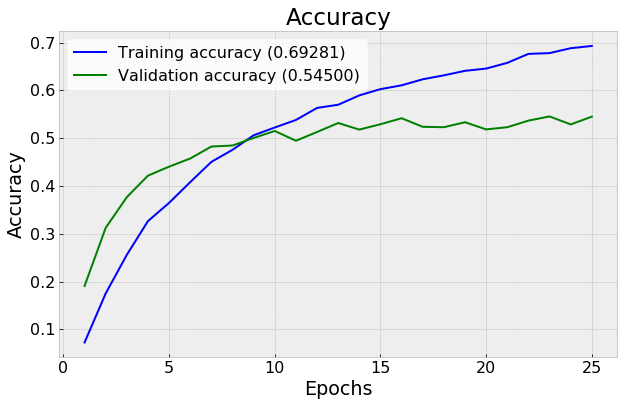

In [22]:
plot_history(history, figsize=(10,6))

In [23]:
# looks like we're starting to overfit, let's see if we can improve by continuing to train with a slower learning rate 
# as gains in val_loss are becoming less frequent

model.optimizer.lr = 1e6
history = model.fit_generator(train_generator, steps_per_epoch=800, epochs=15, 
                        validation_data=validation_generator,
                       callbacks=[checkpointer])

Epoch 1/15
800/800 [==============================] - 407s 509ms/step - loss: 1.0207 - acc: 0.7031 - val_loss: 1.6696 - val_acc: 0.5296

Epoch 00001: val_loss did not improve
Epoch 2/15
800/800 [==============================] - 408s 510ms/step - loss: 0.9880 - acc: 0.7120 - val_loss: 1.6594 - val_acc: 0.5383

Epoch 00002: val_loss did not improve
Epoch 3/15
800/800 [==============================] - 407s 509ms/step - loss: 1.0013 - acc: 0.7094 - val_loss: 1.6362 - val_acc: 0.5392

Epoch 00003: val_loss did not improve
Epoch 4/15
800/800 [==============================] - 410s 513ms/step - loss: 0.9941 - acc: 0.7116 - val_loss: 1.6371 - val_acc: 0.5342

Epoch 00004: val_loss did not improve
Epoch 5/15
800/800 [==============================] - 407s 509ms/step - loss: 0.9626 - acc: 0.7216 - val_loss: 1.6739 - val_acc: 0.5321

Epoch 00005: val_loss did not improve
Epoch 6/15
800/800 [==============================] - 408s 510ms/step - loss: 0.9289 - acc: 0.7285 - val_loss: 1.6792 - val_a

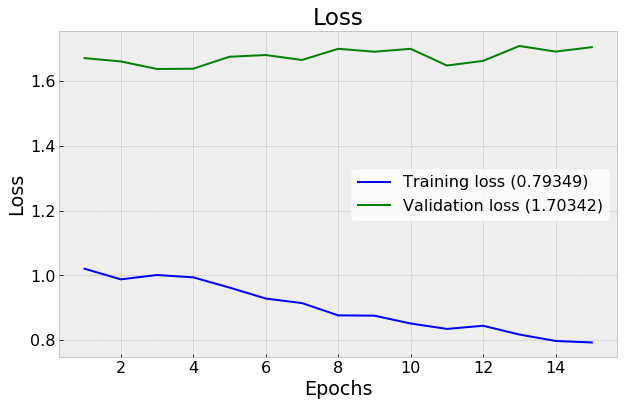

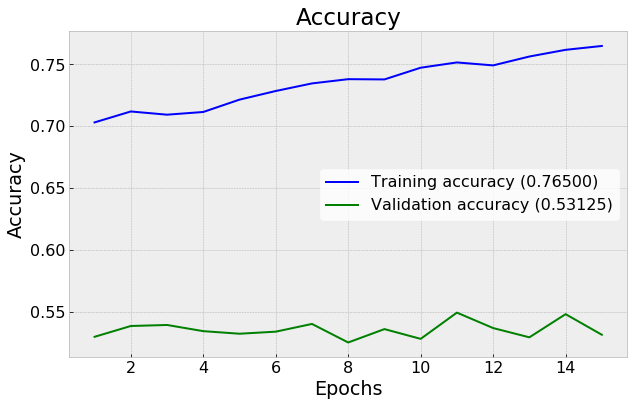

In [27]:
plot_history(history, figsize=(10,6))

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
import itertools

In [13]:
model.load_weights('saved_models/weights.vgg16_BN_finetuned.h5')

In [14]:
# now lets evaluate the model on our unseen test data

y_pred = model.predict_generator(test_generator, max_queue_size =10)

In [19]:
import pandas as pd

In [38]:
# create a dataframe of the predictions to find the most hallmark example of a class in the eyes of the model

results_df = pd.DataFrame(y_pred)
results_df.columns = list(label_dict.values())
results_df.head()

Chihuahua  Japanese_spaniel  Maltese_dog  Pekinese  Shih-Tzu  \
0   0.736405          0.000014     0.000011  0.000255  0.000006   
1   0.698656          0.000084     0.000202  0.000351  0.000020   
2   0.459882          0.015767     0.001433  0.009011  0.000423   
3   0.197420          0.002124     0.032774  0.000147  0.000095   
4   0.209907          0.000209     0.028989  0.000036  0.000687   

   Blenheim_spaniel  papillon  toy_terrier  Rhodesian_ridgeback  Afghan_hound  \
0          0.000002  0.000004     0.001579             0.000040  8.665214e-07   
1          0.000346  0.000314     0.003531             0.000826  2.896016e-04   
2          0.001103  0.004804     0.076115             0.000742  1.334129e-03   
3          0.000378  0.000223     0.018480             0.001778  1.040688e-04   
4          0.000040  0.000061     0.147360             0.002107  1.917554e-04   

          ...           Brabancon_griffon  Pembroke  Cardigan  toy_poodle  \
0         ...                    0.000435  0.127753  0.000742    0.000004   
1         ...                    0.079808  0.064461  0.011908    0.000427   
2         ...                    0.001913  0.049123  0.031855    0.000020   
3         ...                    0.000077  0.016487  0.001703    0.004950   
4         ...                    0.000013  0.000291  0.000072    0.011207   

   miniature_poodle  standard_poodle  Mexican_hairless     dingo     dhole  \
0          0.000057         0.000035          0.000066  0.074075  0.000047   
1          0.000284         0.001377          0.000314  0.002599  0.000224   
2          0.000093         0.000444          0.000973  0.010017  0.000081   
3          0.004851         0.000456          0.001253  0.061423  0.000463   
4          0.008175         0.000761          0.016769  0.004939  0.000064   

   African_hunting_dog  
0             0.000021  
1             0.000008  
2             0.000132  
3             0.000063  
4             0.000529  

[5 rows x 120 columns]

In [95]:
# find most pugly

image = results_df['pug'].idxmax()
image

7270

In [73]:
# need index of all test images

folders = [x[0] for x in os.walk('test')][1:]
files = [os.listdir(f) for f in folders]

In [76]:
flattened_list = [y for x in files for y in x]

In [80]:
files = pd.DataFrame(flattened_list)
files.head()

0
0  n02085620_10074.jpg
1  n02085620_10131.jpg
2   n02085620_1073.jpg
3  n02085620_11337.jpg
4  n02085620_11477.jpg

0    n02110958_609.jpg
Name: 7270, dtype: object


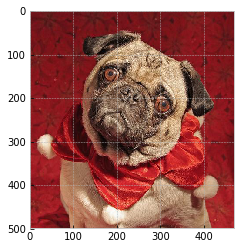

In [94]:
# ok lets find the pug image

pug = files.iloc[image]
print(pug)

display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02110958-pug\n02110958_609.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [98]:
# corgi
image = results_df['Pembroke'].idxmax()
image

8085

In [99]:
corgi = files.iloc[image]
print(corgi)

0    n02113023_3913.jpg
Name: 8085, dtype: object


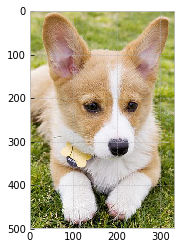

In [100]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02113023-Pembroke\n02113023_3913.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [101]:
# let's look at the most misclassified pairs siberian husky and eskimo dog

image = results_df['Siberian_husky'].idxmax()

husky = files.iloc[image]
print(husky)

0    n02110185_13187.jpg
Name: 6954, dtype: object


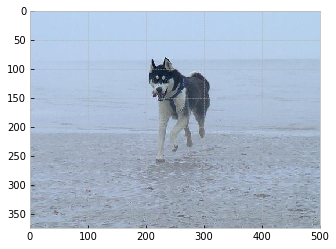

In [102]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02110185-Siberian_husky\n02110185_13187.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [108]:
#... now eskimo dog

image = results_df['Eskimo_dog'].idxmax()

eskimo = files.iloc[image]
print(eskimo)

0    n02110185_699.jpg
Name: 7002, dtype: object


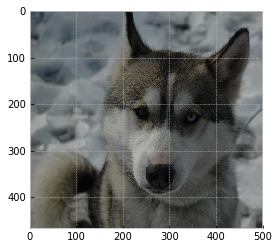

In [110]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02110185-Siberian_husky\n02110185_699.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

#interestingly the model thinks that an image from the Siberian husky folder is the most "Eskimo Dog" even out of the eskimo dog images

In [112]:
# entlebucher

image = results_df['EntleBucher'].idxmax()

EntleBucher = files.iloc[image]
print(EntleBucher)

0    n02108000_1462.jpg
Name: 6375, dtype: object


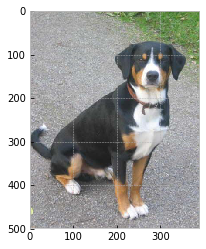

In [115]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02108000-EntleBucher\n02108000_1462.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [116]:
# Greater_Swiss_Mountain_dog
image = results_df['Greater_Swiss_Mountain_dog'].idxmax()

greater_swiss = files.iloc[image]
print(greater_swiss)

0    n02107574_2665.jpg
Name: 6170, dtype: object


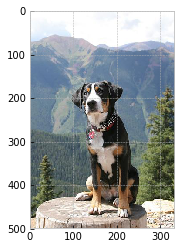

In [117]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02107574-Greater_Swiss_Mountain_dog\n02107574_2665.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [118]:
# Labrador_retriever, 2017 most popular breed

image = results_df['Labrador_retriever'].idxmax()

Labrador_retriever = files.iloc[image]
print(Labrador_retriever)

0    n02099712_7866.jpg
Name: 4528, dtype: object


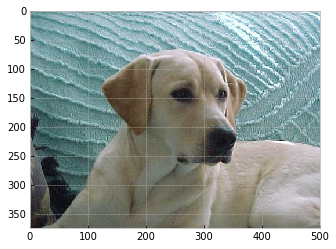

In [119]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02099712-Labrador_retriever\n02099712_7866.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [120]:
# Number 2, German_shepherd

image = results_df['German_shepherd'].idxmax()

German_shepherd = files.iloc[image]
print(German_shepherd)

0    n02106662_16817.jpg
Name: 5954, dtype: object


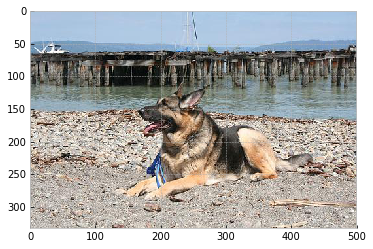

In [121]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02106662-German_shepherd\n02106662_16817.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [122]:
# 3, golden_retriever

image = results_df['golden_retriever'].idxmax()

golden_retriever = files.iloc[image]
print(golden_retriever)

0    n02099601_2994.jpg
Name: 4422, dtype: object


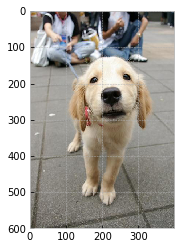

In [123]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02099601-golden_retriever\n02099601_2994.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [124]:
# 4, French_bulldog

image = results_df['French_bulldog'].idxmax()

French_bulldog = files.iloc[image]
print(French_bulldog)

0    n02108915_3702.jpg
Name: 6650, dtype: object


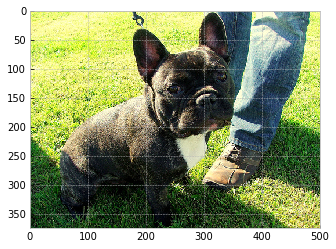

In [125]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02108915-French_bulldog\n02108915_3702.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [126]:
# 6, beagle (#5 english bulldog is not in database)

image = results_df['beagle'].idxmax()

beagle = files.iloc[image]
print(beagle)

0    n02088364_959.jpg
Name: 1086, dtype: object


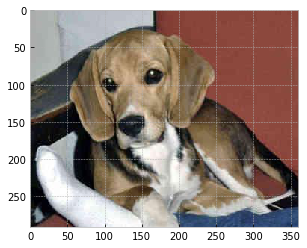

In [127]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02088364-beagle\n02088364_959.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [128]:
# malinois

image = results_df['malinois'].idxmax()

malinois = files.iloc[image]
print(malinois)

0    n02105162_6596.jpg
Name: 5436, dtype: object


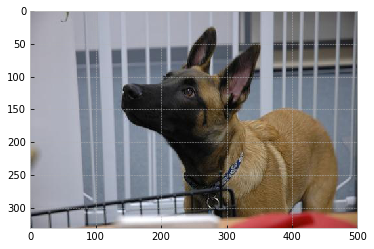

In [129]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02105162-malinois\n02105162_6596.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [130]:
# cairn

image = results_df['cairn'].idxmax()

cairn = files.iloc[image]
print(cairn)

0    n02096177_2842.jpg
Name: 3373, dtype: object


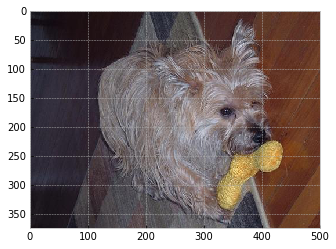

In [131]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02096177-cairn\n02096177_2842.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [134]:
# vizsla

image = results_df['vizsla'].idxmax()

vizsla = files.iloc[image]
print(vizsla)

0    n02100583_7522.jpg
Name: 4699, dtype: object


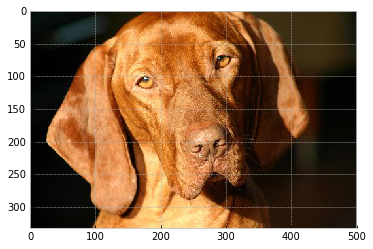

In [135]:
display_image = cv2.imread(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02100583-vizsla\n02100583_7522.jpg''')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(display_image)

In [20]:
y_pred = np.argmax(y_pred, axis=1).astype(int)
y_pred

array([  0,   0,   0, ..., 119, 119, 119])

In [21]:
test_labels = np.load(open('test_labels.npy','rb'))

In [39]:
cm = confusion_matrix(test_labels, y_pred)

#normalize the confusion matrix

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [34]:
breeds = list(label_dict.values())

In [35]:
import seaborn as sns
import pandas as pd

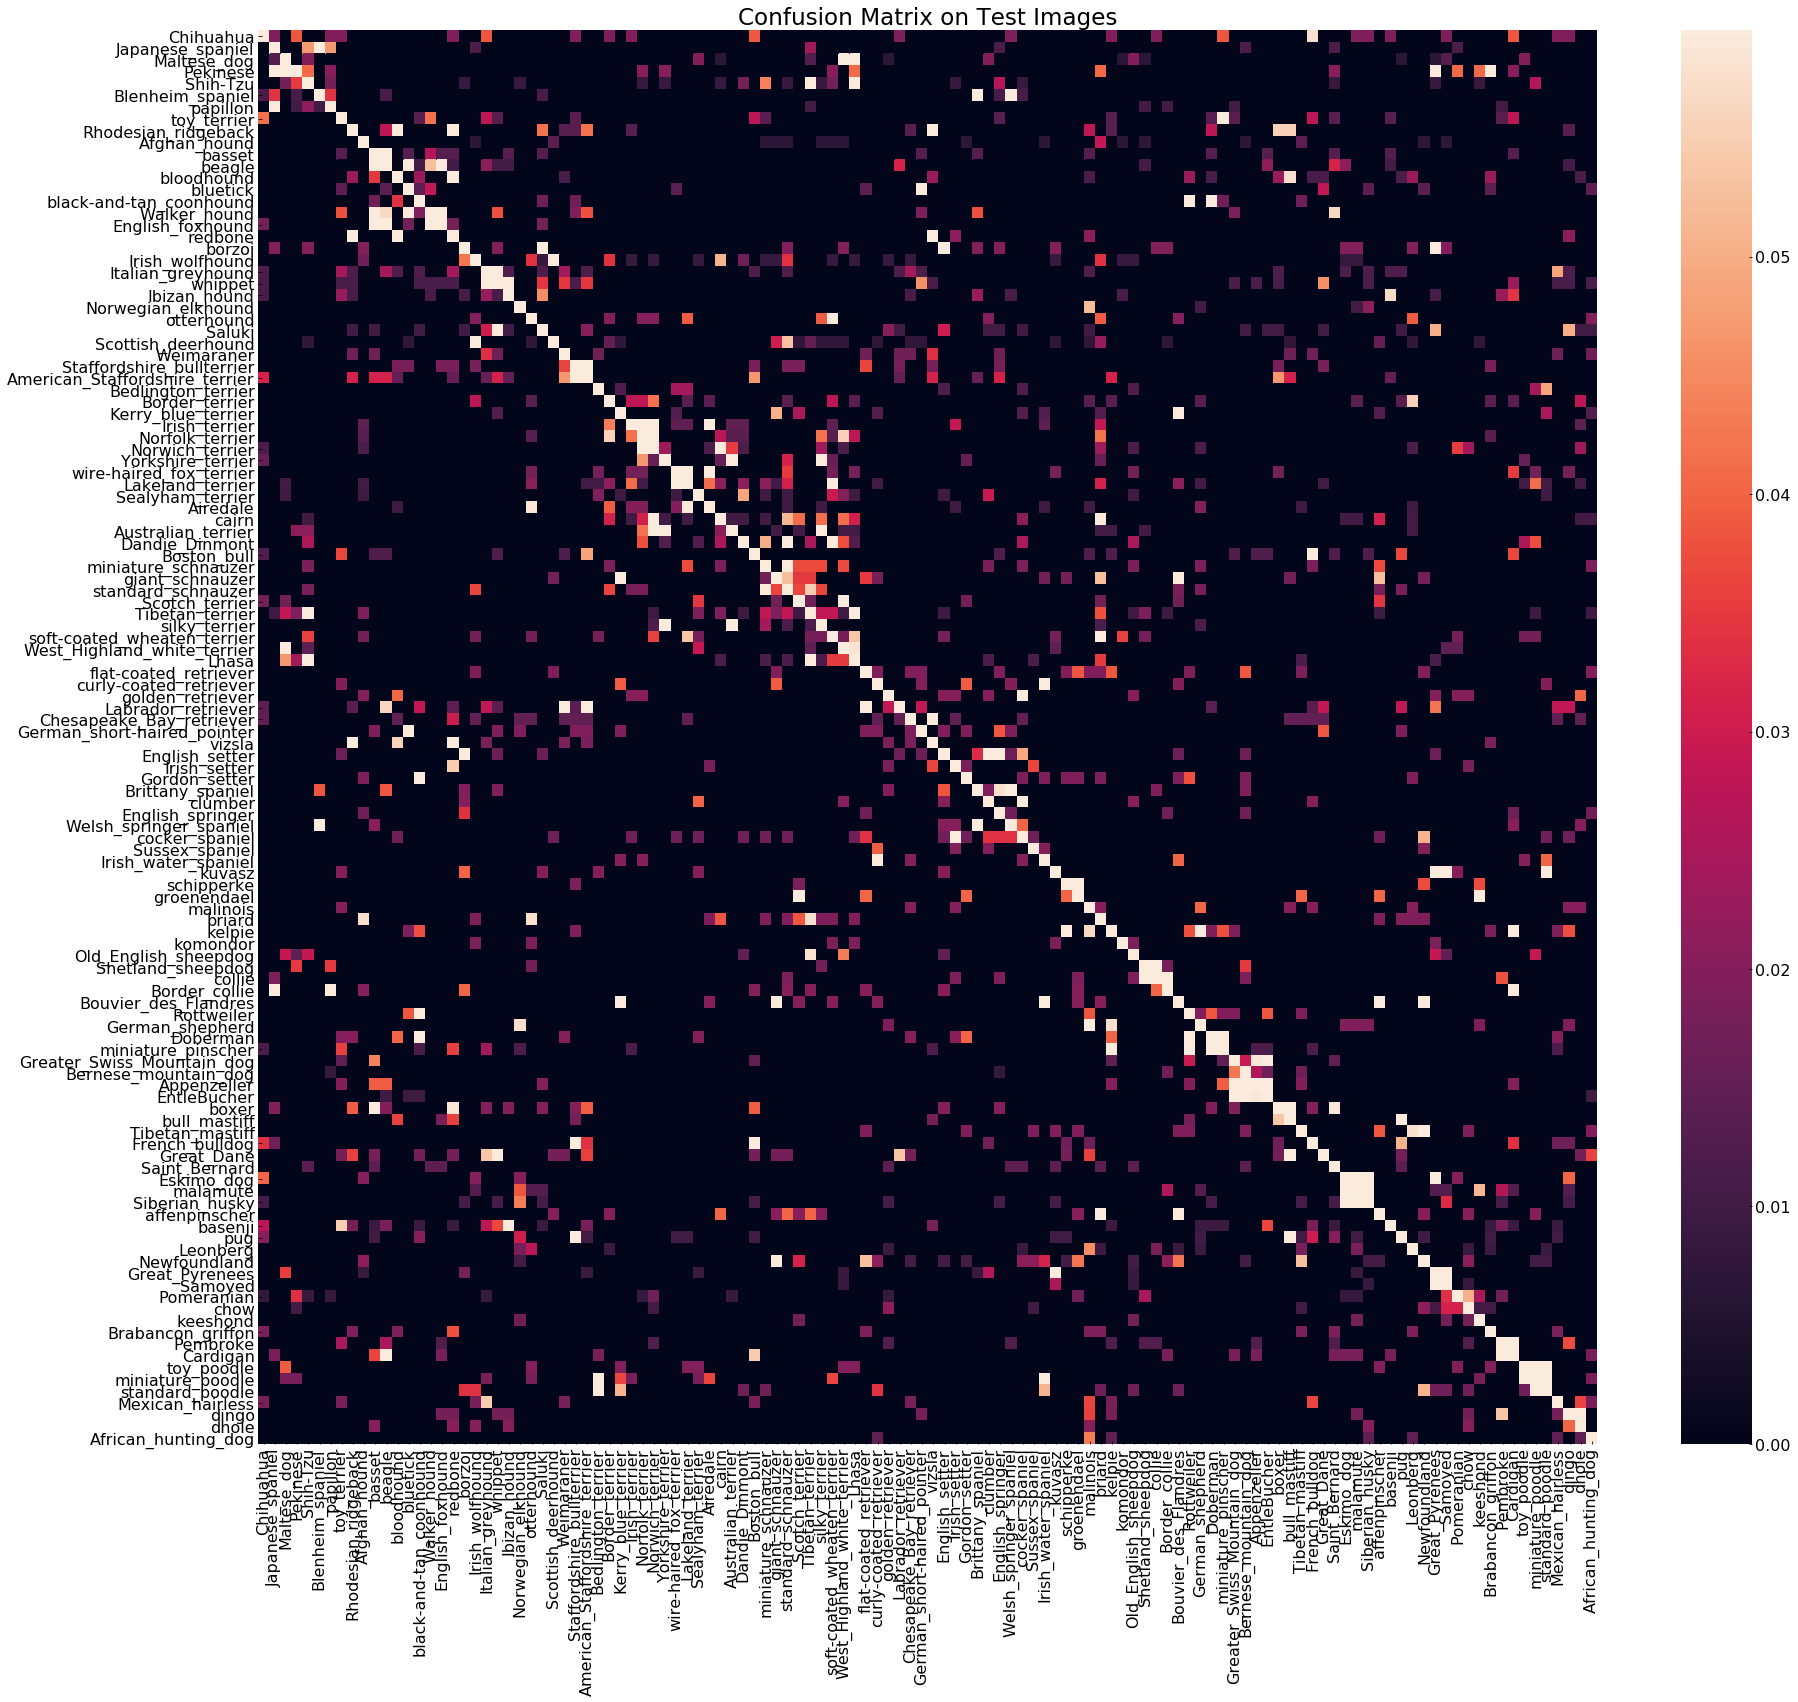

In [42]:
fig, ax = plt.subplots(figsize=(30, 26))
plt.title('Confusion Matrix on Test Images')
_ = sns.heatmap(cm, ax=ax, yticklabels=breeds, xticklabels=breeds, robust=True)


In [82]:
accuracy = model.evaluate_generator(test_generator, max_queue_size=10)

In [83]:
print(accuracy)

[1.4146448807699696, 0.5895104877390228]


In [69]:
'''

# credit to: https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df

df = cm2df(cm, breeds)
'''

In [123]:
df = pd.DataFrame(y_pred, columns=['predicted'], dtype='int')

In [124]:
df.head()

predicted
0          0
1          0
2          0
3          0
4          0

In [125]:
df['actual'] = pd.Series(test_labels).astype('int')
df['count'] = 1
df['count'] = df['count'].astype('int')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8580 entries, 0 to 8579
Data columns (total 3 columns):
predicted    8580 non-null int32
actual       8580 non-null int32
count        8580 non-null int32
dtypes: int32(3)
memory usage: 100.6 KB


In [26]:
# need to create dictionary to assign the numeric labels to string labels 
# first let's reverse the order of the label_dict (again this was datagen.class_indices)

label_dict = {y:x for x,y in label_dict.items()}

In [27]:
for key, value in label_dict.items():
    label_dict[key] = value[10:]

In [133]:
df.replace({"actual": label_dict}, inplace=True)
df.replace({"predicted": label_dict}, inplace=True)

In [51]:
df.head(25)

predicted     actual  count
0            Chihuahua  Chihuahua      1
1            Chihuahua  Chihuahua      1
2            Chihuahua  Chihuahua      1
3            Chihuahua  Chihuahua      1
4            Chihuahua  Chihuahua      1
5       French_bulldog  Chihuahua      1
6            Chihuahua  Chihuahua      1
7       French_bulldog  Chihuahua      1
8                dingo  Chihuahua      1
9            Chihuahua  Chihuahua      1
10              kelpie  Chihuahua      1
11           Chihuahua  Chihuahua      1
12   Italian_greyhound  Chihuahua      1
13           Chihuahua  Chihuahua      1
14            Cardigan  Chihuahua      1
15           Chihuahua  Chihuahua      1
16             basenji  Chihuahua      1
17         toy_terrier  Chihuahua      1
18           Chihuahua  Chihuahua      1
19           Chihuahua  Chihuahua      1
20  Labrador_retriever  Chihuahua      1
21           Chihuahua  Chihuahua      1
22  miniature_pinscher  Chihuahua      1
23           Chihuahua  Chihuahua      1
24           Chihuahua  Chihuahua      1

Text(0.5,1,'Top 30 Misclassified Breed Pairs')

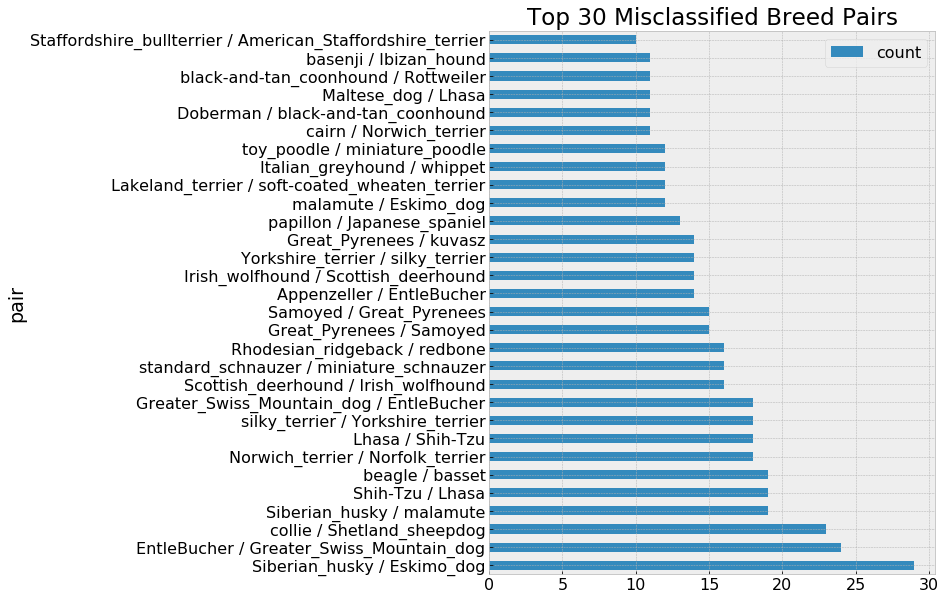

In [164]:
# let's take a look at the top 30 most confused pairs

misclass_df = df[df['actual'] != df['predicted']].groupby(['actual', 'predicted']).sum().sort_values(['count'], ascending=False).reset_index()
misclass_df['pair'] = misclass_df['actual'] + ' / ' + misclass_df['predicted']
misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count'], ascending=False).plot(kind='barh', figsize=(8, 10), x=misclass_df['pair'])
plt.title('Top 30 Misclassified Breed Pairs')

In [166]:
new_misclass_df = df[df['actual'] != df['predicted']].groupby(['actual', 'predicted']).sum().sort_values(['count'], ascending=True).reset_index()
new_misclass_df['pair'] = new_misclass_df['actual'] + ' / ' + new_misclass_df['predicted']

new_misclass_df.tail()

actual                   predicted  count  \
1638        Shih-Tzu                       Lhasa     19   
1639          beagle                      basset     19   
1640          collie           Shetland_sheepdog     23   
1641     EntleBucher  Greater_Swiss_Mountain_dog     24   
1642  Siberian_husky                  Eskimo_dog     29   

                                          pair  
1638                          Shih-Tzu / Lhasa  
1639                           beagle / basset  
1640                collie / Shetland_sheepdog  
1641  EntleBucher / Greater_Swiss_Mountain_dog  
1642               Siberian_husky / Eskimo_dog

Text(0.5,1,'Top 30 Misclassified Breed Pairs')

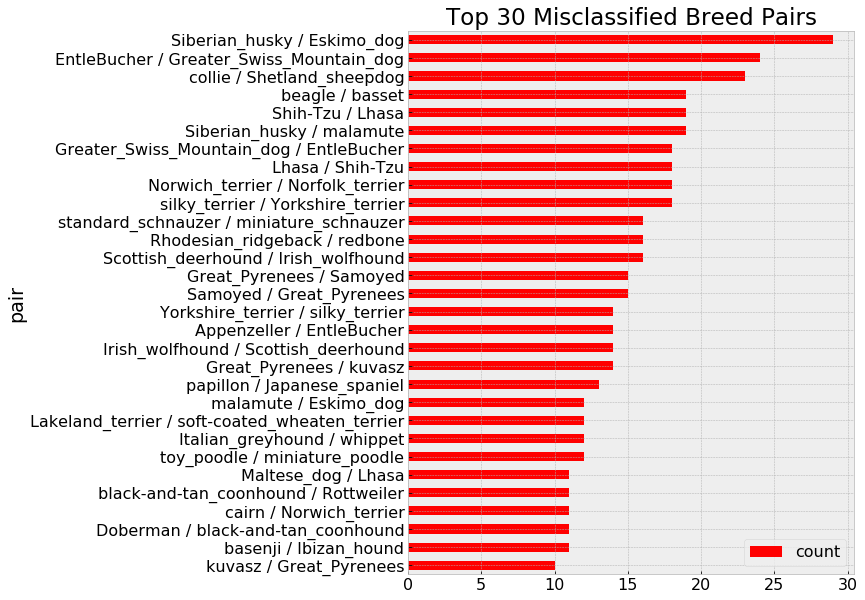

In [169]:

new_misclass_df.tail(30).plot(kind='barh', figsize=(8, 10), x='pair', y='count', color='red')
plt.title('Top 30 Misclassified Breed Pairs')

In [ ]:
# https://stackoverflow.com/questions/41695844/keras-showing-images-from-data-generator?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
'''
x,y = train_generator.next()
for i in range(0,5):
    image = x[i]
    plt.imshow(image.transpose(2,1,0))
    plt.show()
'''

In [92]:
# finally let's get the classification report in case we need it

print(classification_report(y_true=test_labels, y_pred=y_pred, target_names=list(label_dict.values())))

                                precision    recall  f1-score   support

                     Chihuahua       0.42      0.42      0.42        52
              Japanese_spaniel       0.67      0.75      0.71        85
                   Maltese_dog       0.77      0.68      0.72       152
                      Pekinese       0.45      0.39      0.42        49
                      Shih-Tzu       0.49      0.46      0.47       114
              Blenheim_spaniel       0.83      0.67      0.74        88
                      papillon       0.77      0.77      0.77        96
                   toy_terrier       0.56      0.58      0.57        72
           Rhodesian_ridgeback       0.38      0.26      0.31        72
                  Afghan_hound       0.84      0.84      0.84       139
                        basset       0.48      0.71      0.57        75
                        beagle       0.48      0.41      0.44        95
                    bloodhound       0.64      0.55      0.59  

Highest precision rate = Komodor

Lowest Precision rate = briard  

Highest Recall = Norwegian_elkhound   

Lowest Recall = collie 

Highest F1 = Komodor

Lowest F1 = collie

In [23]:
# now let's visualize whats going on in the network itself as we pass images through
# adopted from Keras documentation: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [7]:
from keras import backend as K

from __future__ import print_function

from scipy.misc import imsave
import time

In [8]:
img_width = 224
img_height = 224

In [19]:
layer_name = 'conv2d_5'

In [10]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
input_img = model.input

In [12]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [23]:
%%capture

kept_filters = []
for filter_index in range(200):

    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

In [25]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

In [26]:
# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [27]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [28]:

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img


In [29]:
# save the result to disk
imsave('stitched_filters_%dx%d_2.png' % (n, n), stitched_filters)

# end keras tutorial

c:\users\Abhi\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [6]:
# let's visualize how the model interprets the image data. let's start using a picture that we're familiar with, Pepsi.
# adopted from https://github.com/erikreppel/visualizing_cnns/blob/master/visualize_cnns.ipynb

import cv2

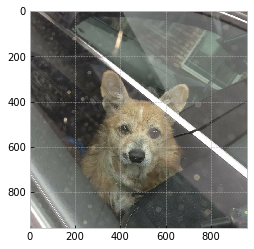

In [8]:
pepsi = cv2.imread(r'''C:\Users\Abhi\Downloads\pepsi.jpg''')
pepsi = cv2.cvtColor(pepsi, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
plt.imshow(pepsi)

In [9]:
pepsi.shape

(960, 960, 3)

In [10]:
pepsi = cv2.resize(pepsi,(224,224))

In [11]:
pepsi = np.reshape(pepsi,[1,224,224,3])

In [13]:
pepsi.shape

(1, 224, 224, 3)

In [14]:
pepsi = np.rollaxis(pepsi, 3, 1)

In [15]:
pepsi.shape

# image is now in shape appropriate for VGG16BN

(1, 3, 224, 224)

In [68]:
pepsi_predict_proba = model.predict(pepsi)

In [81]:
pepsi_predict_class = np.argmax(pepsi_predict_proba)
label_dict[pepsi_predict_class]

'Airedale'

In [75]:
# bummer not a good prediction, let's see how confident the model was

pepsi_top_prob = np.max(pepsi_predict_proba)
pepsi_top_prob

0.36948738

In [137]:
#let's create a function to apply these same steps over other images

def predict_image(filepath, model=model):
    '''
    Takes a single image and returns class/breed prediction and accuracy
    Dependencies: needs os, cv2 and keras, dependency file or perhaps annex to docker
    Args: filepath of image (no quotes), optional: specify the model, will default to current model in environment
    '''
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #cv2 uses BGR, so reverting back to RGB
    print('Uploaded Image...')
    plt.imshow(img)
    
    #resize and reshape for model input
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])
    img = np.rollaxis(img, 3, 1)
    
    #predict
    prediction = model.predict(img)
    
    #print results
    class_predict = np.argmax(prediction)
    breed = label_dict[class_predict]
    print('Woof! The model predicted the breed as...{}!'.format(breed))
    top_prob = np.max(prediction)
    print('...with a confidence of {0:.2f}%.'.format(top_prob*100))
    
          

Uploaded Image...
Woof! The model predicted the breed as...malinois!
...with a confidence of 40.51%.


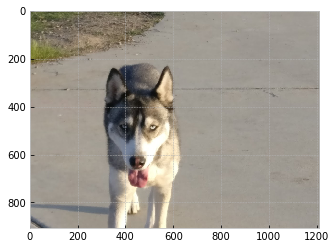

In [111]:
predict_image('C:\\Users\\Abhi\\Downloads\\IMG_20180221_073001.jpg')

Uploaded Image...
Woof! The model predicted the breed as...pug!
...with a confidence of 48.72%.


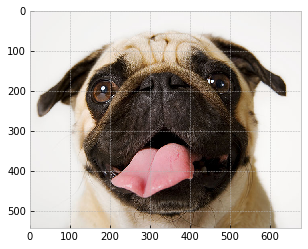

In [110]:
predict_image('C:\\Users\\Abhi\\Downloads\\pug.jpg')

#yaaaaaaaaas
# this is especially encouraging as pug/bull mastiff was the 2nd most common misclassification

Uploaded Image...
Woof! The model predicted the breed as...French_bulldog!
...with a confidence of 56.05%.


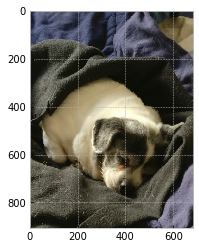

In [112]:
predict_image('C:\\Users\\Abhi\\Downloads\\maggie.jpg')

# trick question, even my parents don't know what kind of dog Maggie is

Uploaded Image...
Woof! The model predicted the breed as...cairn!
...with a confidence of 35.88%.


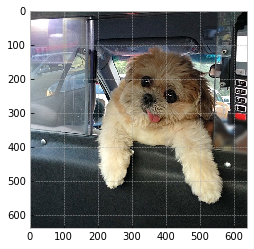

In [114]:
predict_image('C:\\Users\\Abhi\\Downloads\\marnie.jpg')

Uploaded Image...
Woof! The model predicted the breed as...French_bulldog!
...with a confidence of 97.15%.


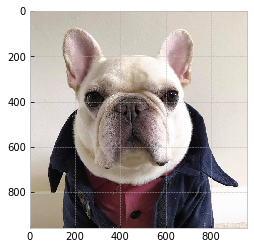

In [115]:
predict_image('C:\\Users\\Abhi\\Downloads\\barkley.jpg')

Uploaded Image...
Woof! The model predicted the breed as...vizsla!
...with a confidence of 30.78%.


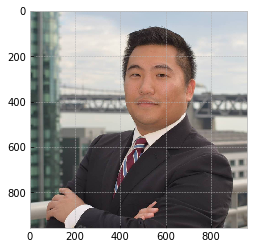

In [116]:
# ok so which breed do I look like?

predict_image('C:\\Users\\Abhi\\Downloads\\1510749_671062136947_5867944268483557830_n.jpg')

Uploaded Image...
Woof! The model predicted the breed as...papillon!
...with a confidence of 99.50%.


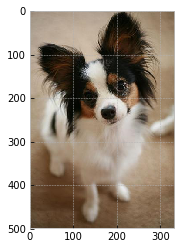

In [139]:
# in conjunction with the human-performance study, passing in the images for the model
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02086910-papillon\n02086910_1775.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...Saluki!
...with a confidence of 18.06%.


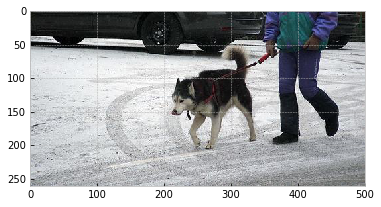

In [140]:
# 2 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02109961-Eskimo_dog\n02109961_18381.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...EntleBucher!
...with a confidence of 86.99%.


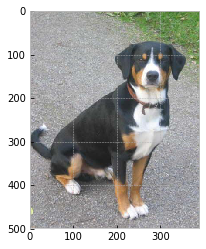

In [141]:
# 3 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02108000-EntleBucher\n02108000_1462.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...West_Highland_white_terrier!
...with a confidence of 54.76%.


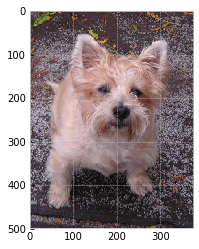

In [142]:
# 4 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02096177-cairn\n02096177_1390.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...malamute!
...with a confidence of 51.96%.


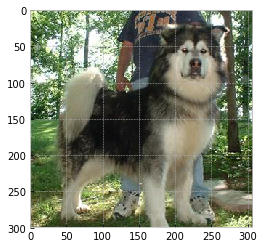

In [143]:
# 5 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02110063-malamute\n02110063_566.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...Gordon_setter!
...with a confidence of 97.43%.


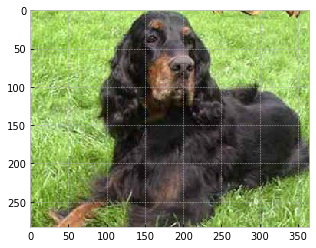

In [144]:
# 6 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02101006-Gordon_setter\n02101006_3379.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...Border_collie!
...with a confidence of 45.00%.


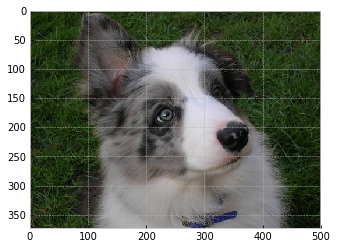

In [145]:
# 7 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02106166-Border_collie\n02106166_152.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...Shih-Tzu!
...with a confidence of 15.16%.


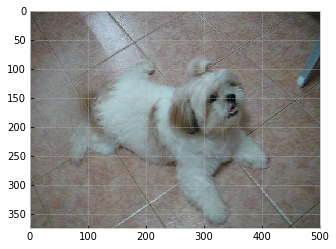

In [146]:
# 8 of 10
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02086240-Shih-Tzu\n02086240_3424.jpg''')

Uploaded Image...
Woof! The model predicted the breed as...Tibetan_mastiff!
...with a confidence of 85.87%.


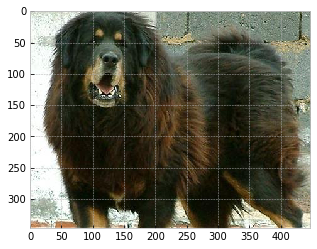

In [147]:
# 10 of 10 (the 9th was Sir Charles Barkely)
predict_image(r'''C:\Users\Abhi\Documents\Capstone\datasets\test\n02108551-Tibetan_mastiff\n02108551_1543.jpg''')